### Завантажимо необхідні бібліотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import networkx as nx
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

### Завантажимо дані

In [2]:
#Load data
schars = pd.read_csv('simpsons_characters.csv')
sepisodes = pd.read_csv('simpsons_episodes.csv')
slines = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
locations = pd.read_csv('simpsons_locations.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)

### Дослідимо персонажів серіалу

In [3]:
schars.head(10)

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN
2,13,Tattoo Man,tattoo man,NaN
3,16,DOCTOR ZITSOFSKY,doctor zitsofsky,NaN
4,20,Students,students,NaN
5,24,Little Boy,little boy,NaN
6,26,Lewis Clark,lewis clark,NaN
7,27,Little Girl,little girl,NaN
8,29,Bubbles,bubbles,NaN
9,30,Moldy,moldy,NaN


### Співвідношення чоловічих та жіночих персонажів

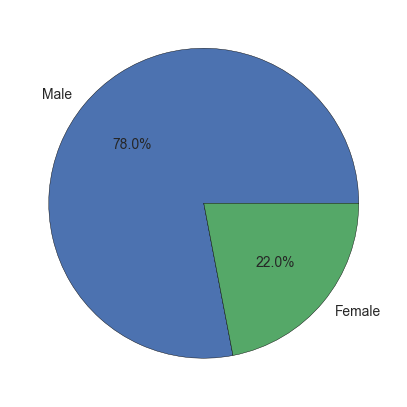

In [4]:
genderplot = schars.gender.value_counts().plot.pie(labels=('Male','Female'),figsize=(5,5),autopct='%1.1f%%')
genderplot.set_ylabel('')

### Дослідимо, як багато слів в цілому говорять персонажі

In [5]:
slines.head(5)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


## 10 персонажів, які розмовляють найбільше

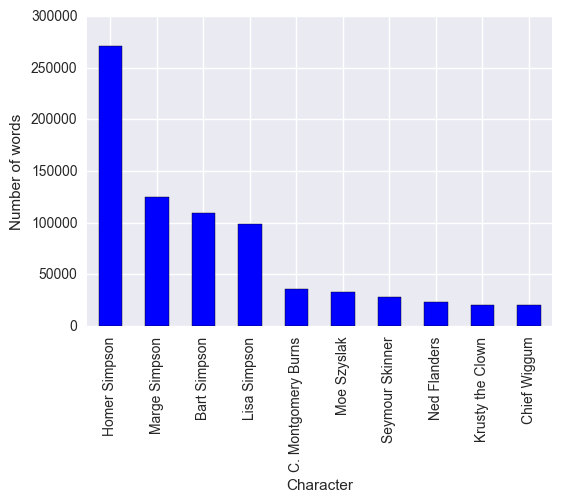

In [6]:
fig = plt.figure()
cwords = slines.groupby(['raw_character_text'])['word_count'].sum().sort_values(ascending=False)[:10].plot(kind='bar',color='blue')
cwords.set_xlabel('Character')
cwords.set_ylabel('Number of words')

## 10 локацій, де розмовляють найбільше

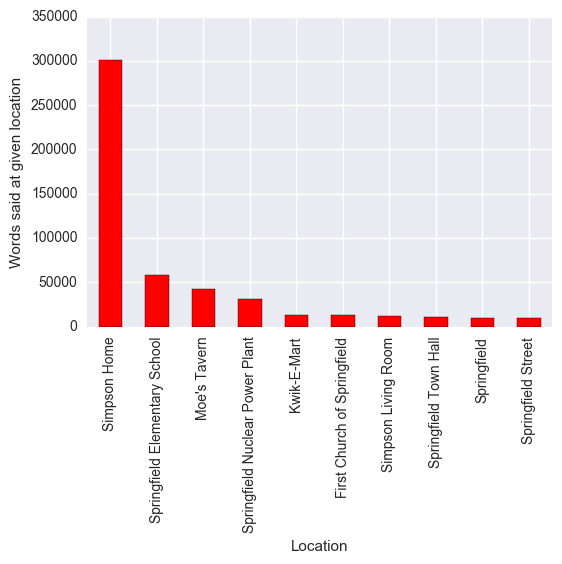

In [7]:
#Number of lines
locs = slines.groupby(['raw_location_text'])['word_count'].sum().sort_values(ascending=False)[:10].plot(kind='bar',color='red')
locs.set_xlabel('Location')
locs.set_ylabel('Words said at given location')

## Дослідимо, з ким найбільше розмовляють персонажі.

Діалогом вважатимемо, якщо персонажі знаходяться в одній локації і розмовляють один за одним

In [8]:
characters = pd.read_csv('simpsons_characters.csv', index_col='id')
script_lines = pd.read_csv('simpsons_script_lines.csv', index_col='id', low_memory=False, usecols=list(range(13)))
episode_ids = script_lines['episode_id'].unique()
DG = nx.DiGraph()
for episode_id in episode_ids:
    episode = script_lines[script_lines['episode_id'] == episode_id]
    current_room, current_character = -1, -1
    previous_room, previous_character = -2, -2
    for line_id, row in episode.sort_values(by="timestamp_in_ms").iterrows():
        if row['speaking_line']:
            try:
                current_room = int(row['location_id'])
            except:
                current_room = -1
                
            try:
                current_character = int(row['character_id'])
            except:
                current_character = -1
                
            if current_room == previous_room:
                if ((previous_character not in DG) or 
                   (current_character not in DG[previous_character])):
                    DG.add_edge(previous_character, current_character, weight=1)
                else:
                    DG[previous_character][current_character]['weight'] += 1

            previous_character = current_character
            previous_room = current_room      

In [9]:
avg_weight = np.mean([DG[e[0]][e[1]]['weight'] for e in DG.edges_iter(data=True)])
max_weight = np.amax([DG[e[0]][e[1]]['weight'] for e in DG.edges_iter(data=True)])
useful_nodes = [e[0] for e in DG.edges_iter(data=True) 
                     if (DG[e[0]][e[1]]['weight'] > avg_weight * 45) 
                        and (e[0] != -1) 
                        and (e[0] != e[1])]
useful_DG = DG.subgraph(useful_nodes)

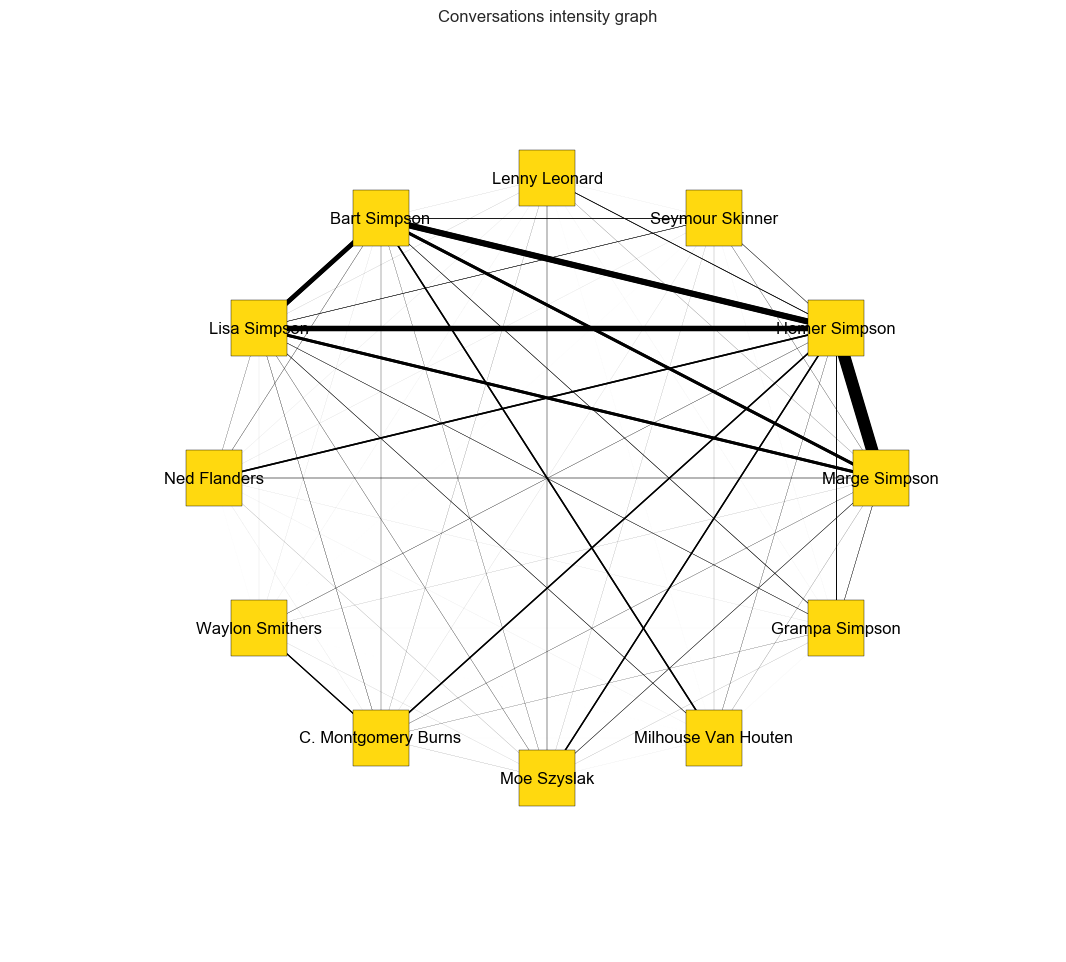

In [10]:
# here we get names from IDs
labels = {node: characters.loc[node]['name']  for node in useful_DG.nodes()}
edges = useful_DG.edges()
# Line width is proportional to the conversation intensity
weights = [useful_DG[u][v]['weight'] / max_weight * 10 for u, v in edges]
plt.figure(figsize=(10, 9))
# I turned off arrows, so width shows MAXIMUM of 
# (char_1, char_2) and (char_2, char_1) dialogue lines
nx.draw_circular(useful_DG, arrows=False, edges=edges, with_labels=True, node_shape='s',
                 labels=labels, node_color='#FFD90F', width=weights, node_size=1600)
plt.title("Conversations intensity graph")
plt.show()

# Wordclouds для 4 головних персонажів

In [11]:
data_script_lines = pd.read_csv("simpsons_script_lines.csv",
                    error_bad_lines=False,
                    warn_bad_lines=False,
                    low_memory=False)

In [12]:
# More "not interesting" words:
ADDITIONAL_STOPWORDS = ["im", "know", "dont", "will", "got", "now", "nan", "ive", "whats", "hes", 
                        "shes", "its", "cant", "mr", "mrs", "ill", "let", "lets", "youre", "oh", "one",
                        "thats", "theres", "ye", "go", "day", "say", "didnt", "wont", "aw", "uh","ah", "oh","two",
                        "isnt","ol", "youll","yes", "well", "us", "see", "hey", "ho", "look","call", "gonna", "youve",
                        "us", "take"]

In [13]:
custom_char_index = {"Maggie": 105, "Marge": 1, "Bart": 8, "Lisa": 9, "Moe": 17,  "Seymour": 3,
                     "Ned": 11, "Grampa": 31, "Wiggum": 71, "Milhouse": 25, "Smithers": 14,
                     "Nelson": 101, "Edna": 40, "Selma": 22, "Barney": 18, "Patty": 10, "Martin": 38,
                     "Todd": 5, "Rod": 121, "Homer": 2, "Cletus": 1413, "Gil": 2369,
                     "Moleman": 963, "Duffman": 2277, "Apu": 208, "Burns": 15, "Dr. Nick": 349,
                     "Dr. Hibbert": 332, "Sideshow Bob": 153,"Krusty": 139, "Fat Tony": 568, "Snake": 518,
                     "Ralph": 119}

In [14]:
def draw_wc(character, data, add_stopwds):
    """
    Draw a nice wordcloud representing the most frequent words for a given character.
    
    Parameters
    ----------
    character (str): the character name (must be a key from custom_char_index)
    data (DataFrame): the script lines data
    add_stopwds (list): additional stopwords for pre-processing
    
    Returns
    -------
    wc (WordCloud)
    
    """
    # Get all the lines from the character of interest:
    chosen_char_id = custom_char_index[character]
    df_charac = data[data["character_id"]==str(chosen_char_id)]
    charac_lines = list(df_charac["normalized_text"].values.astype(str))
    # Transform into one big string:
    charac_lines_one_str = ' '.join(charac_lines)
    # Build the stopwords set:
    stopwords = set(STOPWORDS)
    for w in add_stopwds:
        stopwords.add(w)
    # Instanciate the Wordcloud object:
    wc = WordCloud(background_color="black",
                   max_words=200,
                   stopwords=stopwords,
                   relative_scaling=0.5,
                   width=500,
                   height=350)
    # Generate the wordcloud using the big string:
    wc.generate(charac_lines_one_str)
    return wc

In [15]:
def plot_wordcloud(character):
    char_wc = draw_wc(character, data_script_lines, ADDITIONAL_STOPWORDS)
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(char_wc)
    plt.title(character, fontsize=32)
    plt.axis("off")

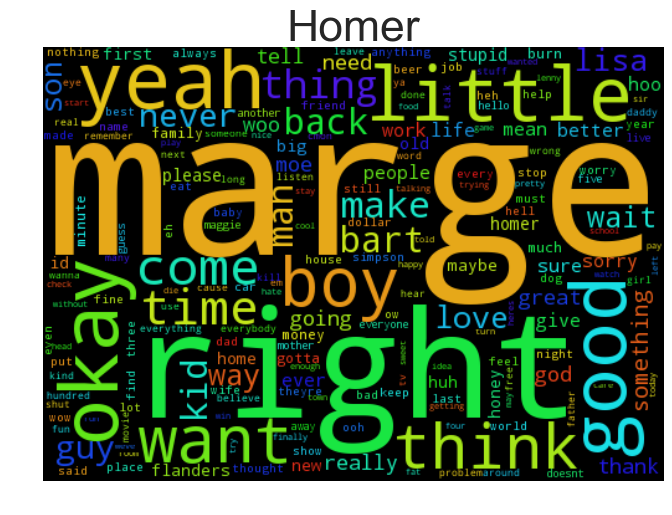

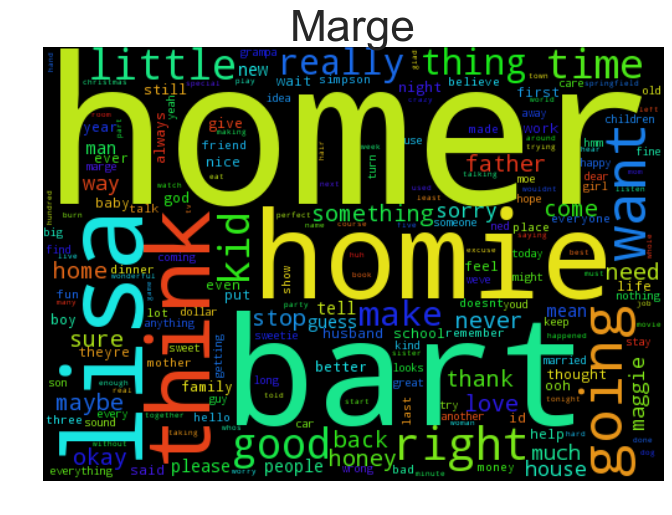

In [16]:
plot_wordcloud("Homer")
plot_wordcloud("Marge")

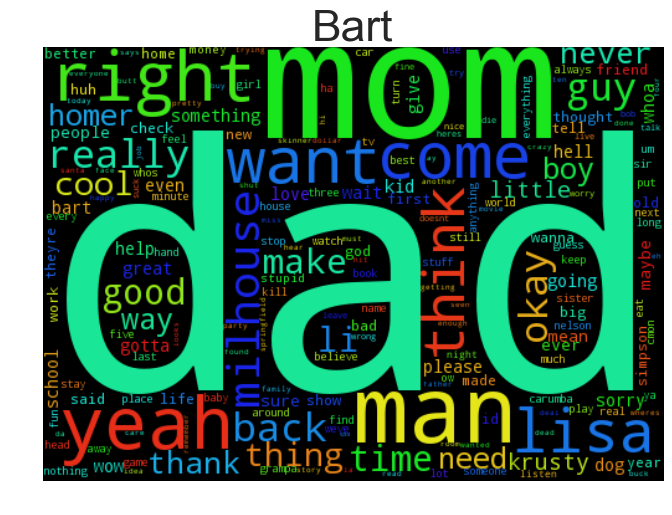

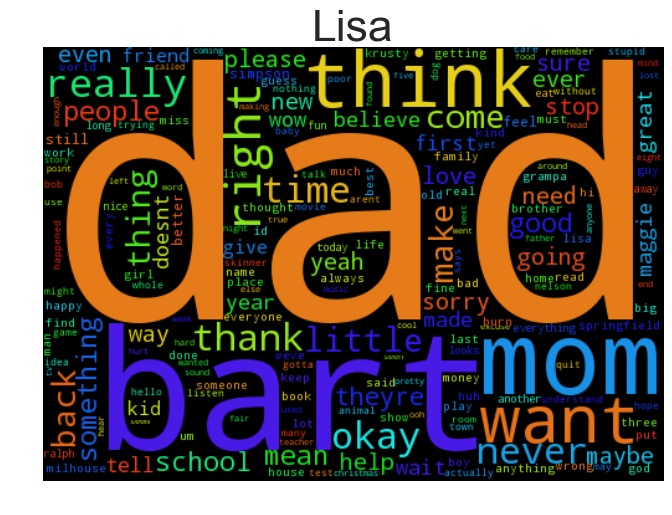

In [17]:
plot_wordcloud("Bart")
plot_wordcloud("Lisa")

In [18]:
sepisodes.head(5)

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,10,Homer's Night Out,1990-03-25,7G10,1,10,10,30.3,50816.0,7.4,1511.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/275197507879
1,12,Krusty Gets Busted,1990-04-29,7G12,1,12,12,30.4,62561.0,8.3,1716.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/288019523914
2,14,"Bart Gets an ""F""",1990-10-11,7F03,2,1,14,33.6,59575.0,8.2,1638.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459671
3,17,Two Cars in Every Garage and Three Eyes on Eve...,1990-11-01,7F01,2,4,17,26.1,64959.0,8.1,1457.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260537411822
4,19,Dead Putting Society,1990-11-15,7F08,2,6,19,25.4,50691.0,8.0,1366.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459670


## Середній IMDB Rating для кожного сезону

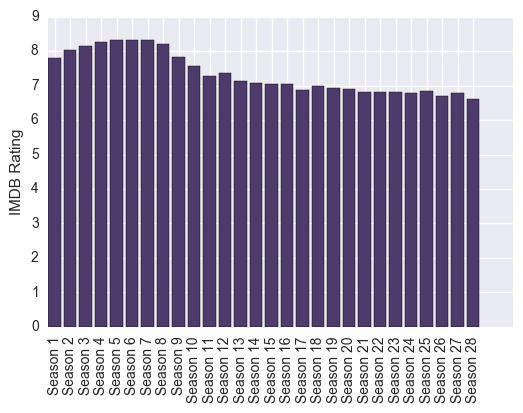

In [19]:
mean_episode_ratings = sepisodes.groupby('season')['imdb_rating'].mean()
ind = np.arange(len(mean_episode_ratings))
labels = ["Season {season}".format(season = season) for season in mean_episode_ratings.index]
plt.bar(ind, mean_episode_ratings, color=(.3,.23,.42))
plt.gca().set_xticks(ind + .4)
plt.gca().set_xticklabels(labels)
plt.ylabel("IMDB Rating")
plt.xticks(rotation=90)
plt.show()

## Середня кількість глядачів сезону

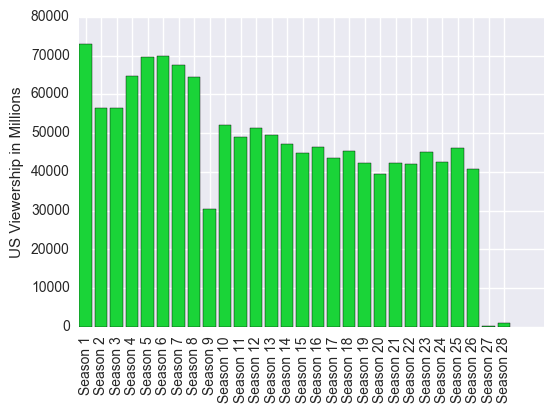

In [20]:
mean_episode_views = sepisodes.groupby('season')['views'].mean()
ind = np.arange(len(mean_episode_views))
labels = ["Season {season}".format(season = season) for season in mean_episode_views.index]
plt.bar(ind, mean_episode_views, color=(.1,.83,.22))
plt.gca().set_xticks(ind + .4)
plt.gca().set_xticklabels(labels)
plt.ylabel("US Viewership in Millions")
plt.xticks(rotation=90)
plt.show()

## Подивимось, як змінювався рейтинг та кількість переглядів для кожного з епізодів

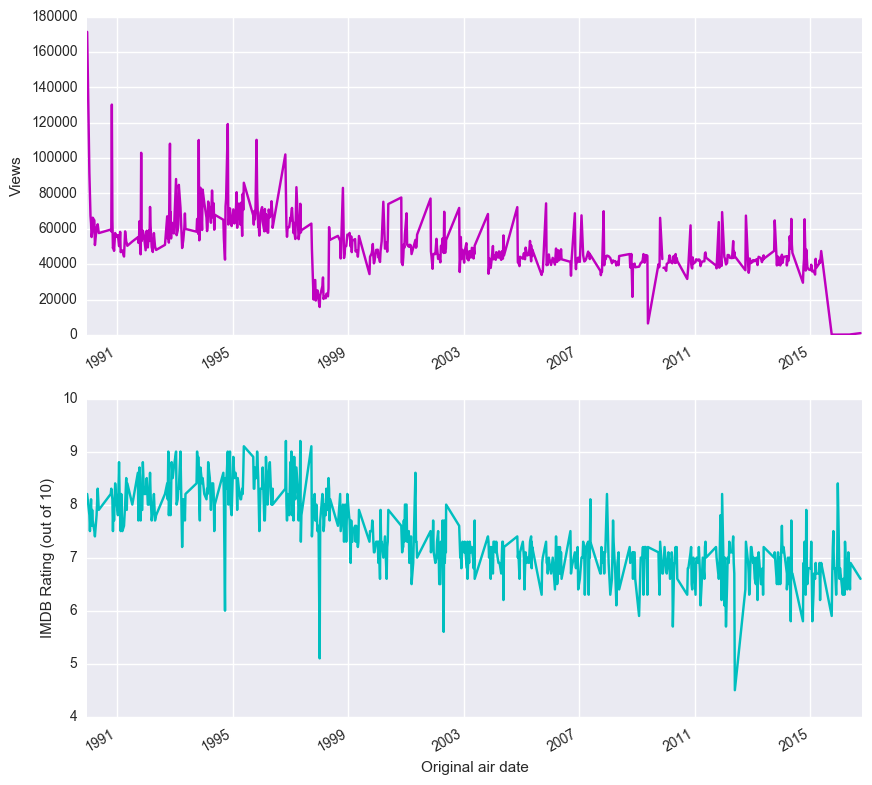

In [21]:
f,ax = plt.subplots(2,1,figsize=(10,5))
#views
viewers = sepisodes.set_index('original_air_date')['views']
viewers.index = pd.to_datetime(viewers.index)
viewers_plot = viewers.plot(ax=ax[0],x='test',color='m',figsize=(10,10))
viewers_plot.set_xlabel('')
viewers_plot.set_ylabel('Views')

#Ratings
rating = sepisodes.set_index('original_air_date')['imdb_rating']
rating.index = pd.to_datetime(rating.index)
rating_plot = rating.plot(ax=ax[1],x='test',color='c',figsize=(10,10))
rating_plot.set_xlabel('Original air date')
rating_plot.set_ylabel('IMDB Rating (out of 10)')